In [1]:
import os
import scipy
from scipy import signal
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
import glob
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


In [2]:
out_dir='output_images/test_images/undistorted/'

# load pickled distortion matrix
with open('camera_dist_pickle_notebook.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [3]:
# Visualize undistortion on test images

images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = out_dir+image_name
    cv2.imwrite(write_name,dst)
    print(write_name)
    cv2.imshow('dst', dst)
    cv2.waitKey(500)
cv2.destroyAllWindows()

output_images/test_images/undistorted/straight_lines1.jpg
output_images/test_images/undistorted/straight_lines2.jpg
output_images/test_images/undistorted/test1.jpg
output_images/test_images/undistorted/test2.jpg
output_images/test_images/undistorted/test3.jpg
output_images/test_images/undistorted/test4.jpg
output_images/test_images/undistorted/test5.jpg
output_images/test_images/undistorted/test6.jpg


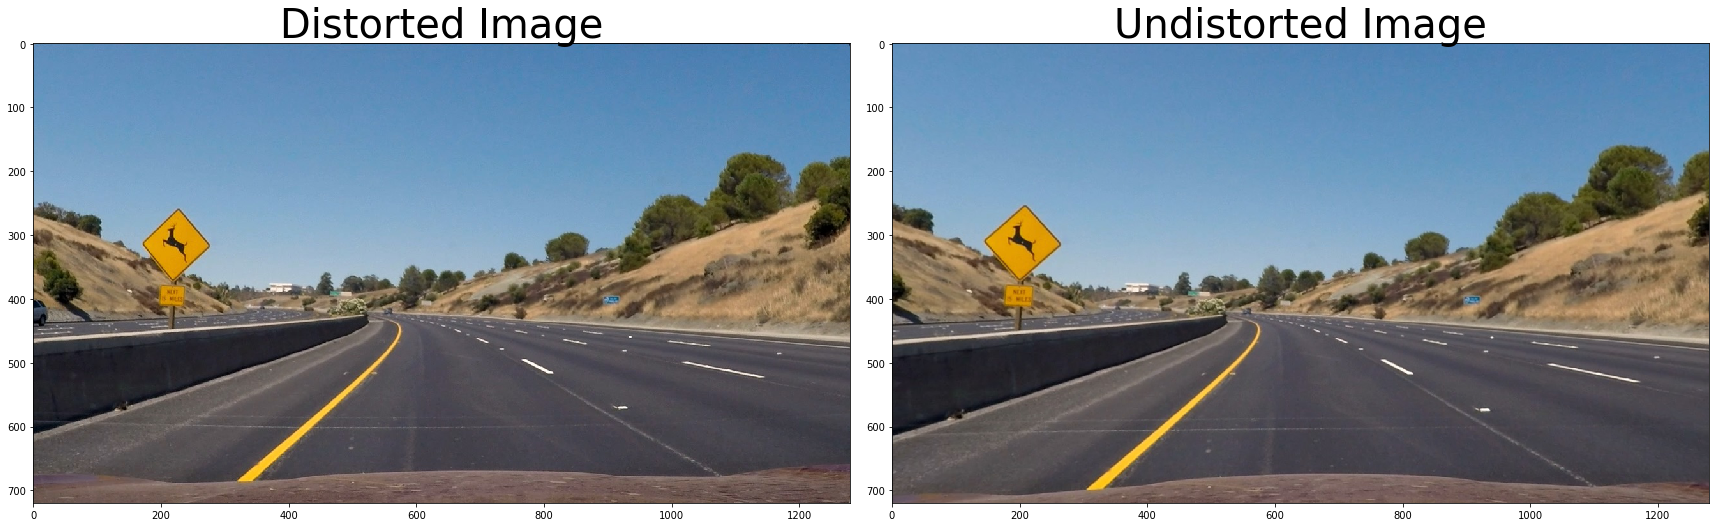

In [4]:
#plot one distorted and undistorted image side by side
img = plt.imread('test_images/test2.jpg')
undistort =  cv2.undistort(img, mtx, dist, None, mtx)


# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Distorted Image', fontsize=40)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=40)

In [5]:
#Define list of helper functions
def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def magnitude_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Function which uses both gradient and colour space information to detect
def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),dir_thresh=(0.7,1.3)):
    
    img = np.copy(img)
      
    # Threshold x gradient
    sxbinary = abs_sobel_thresh(img,'x',sx_thresh[0],sx_thresh[1])
    
    # Threshold saturation channel
    s_binary = hls_select(img,s_thresh) 

    # Threshold lightness
    dir_binary = dir_threshold(img,15, dir_thresh)
    
    channels = 255*np.dstack(( dir_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((dir_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels



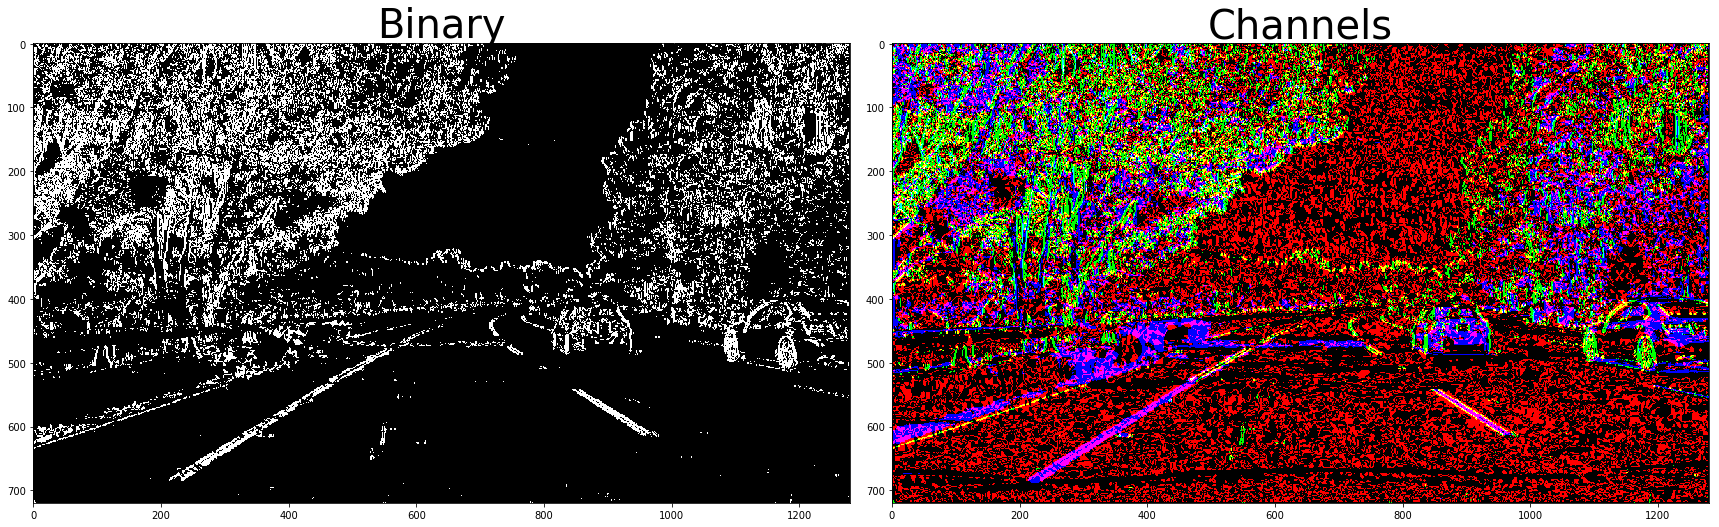

In [6]:
#plot Binary lane detection output and 3 channels used to detect landes
out_dir='output_images/test_images/binarize/'

img = plt.imread('test_images/test5.jpg')

shape = img.shape
binary,channels = binarize(img)
plt.imsave(out_dir+'binary.jpg',binary)
plt.imsave(out_dir+'channels.jpg',channels)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary)
ax1.set_title('Binary', fontsize=40)

ax2.imshow(channels)
ax2.set_title('Channels', fontsize=40)

In [7]:
def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

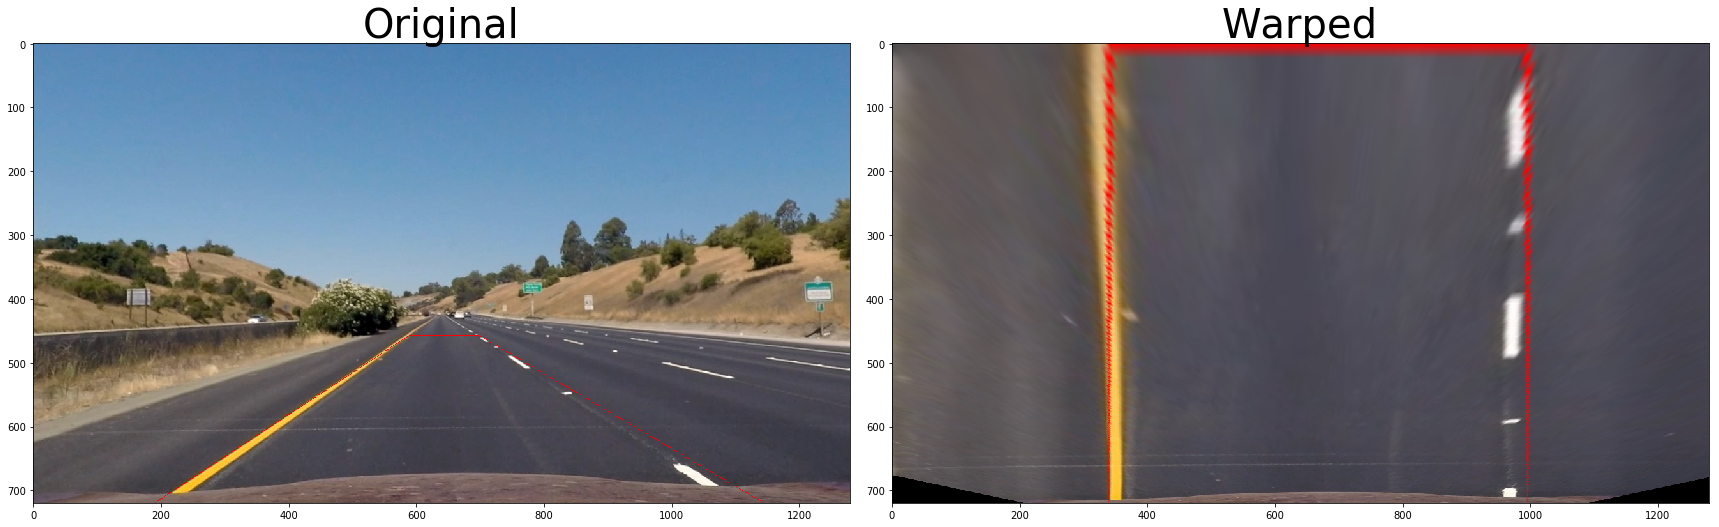

In [8]:
## Perform perspective transform on one image

out_dir='output_images/test_images/perspective/'

img=plt.imread('test_images/straight_lines1.jpg')
corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])

img = cv2.undistort(img, mtx, dist, None, mtx)

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)

warped,_ = warp(img) 
plt.imsave(out_dir+'straight_red.jpg',img)
plt.imsave(out_dir+'straight_red_warped.jpg',warped)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped', fontsize=40)

In [9]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [10]:
def warp_pipeline(img):
    undist = undistort(img)    
    result,_ = warp(undist)
    result = region_of_interest(result)
    return result
    
def warp_binarize_pipeline(img):
    undist = undistort(img)
    binary,_  = binarize(undist)
    result,_  = warp(binary)
    result = region_of_interest(result)
    return result 

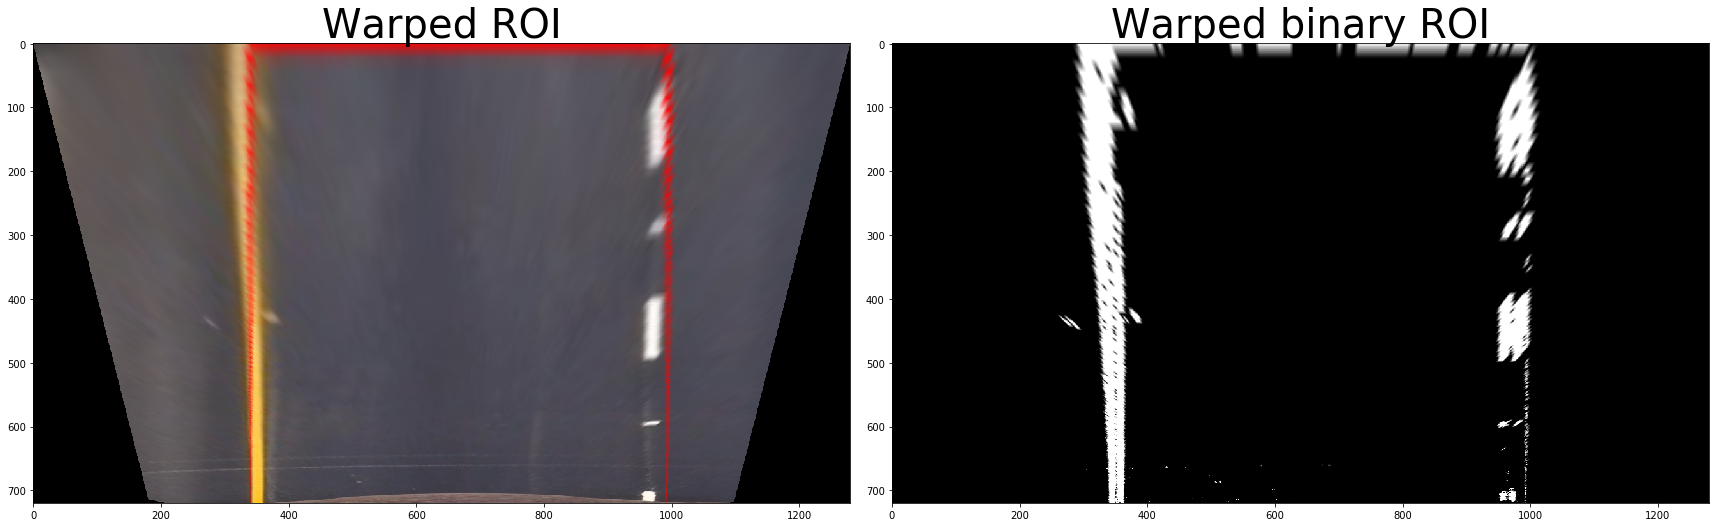

In [11]:
warp_roi = warp_pipeline(img)
warp_binary_roi = warp_binarize_pipeline(img)

plt.imsave(out_dir+'warp_roi_straight_lines1.jpg',warp_roi)
plt.imsave(out_dir+'warp_binary_roi_straight_lines1.jpg',warp_binary_roi)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_roi)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warp_binary_roi)
ax2.set_title('Warped binary ROI', fontsize=40)

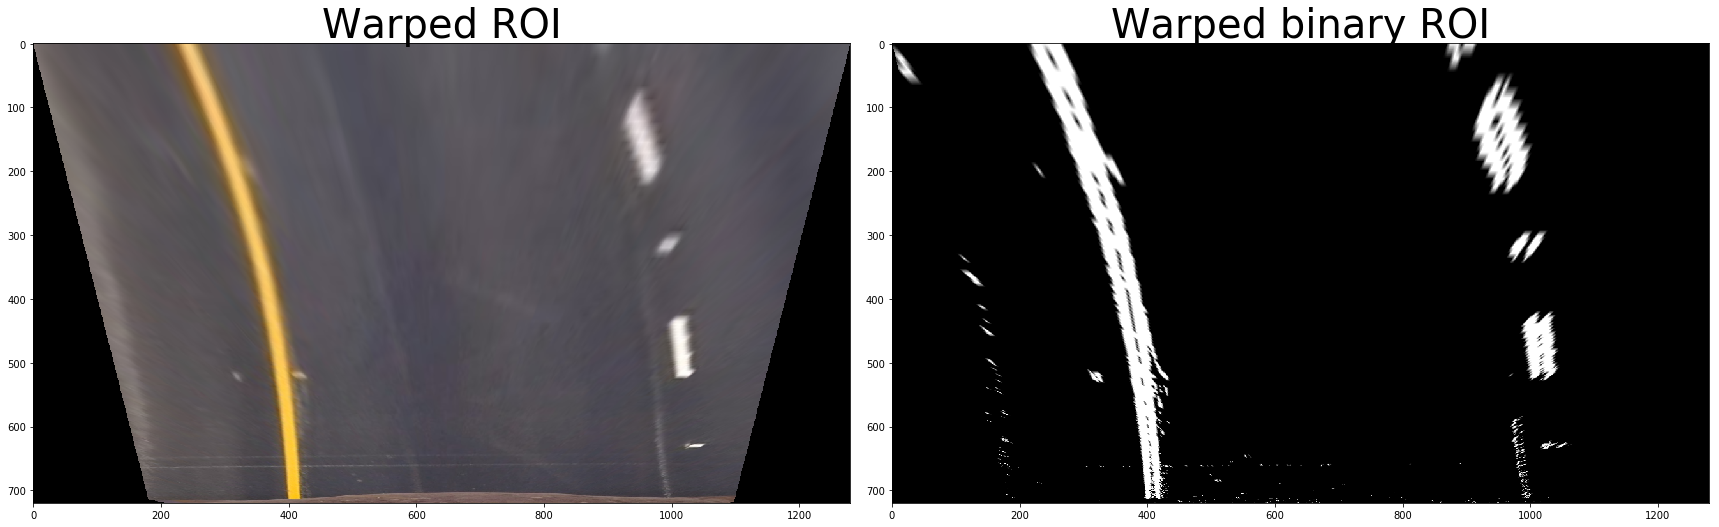

In [12]:
# now back to the test image
img=plt.imread('test_images/test2.jpg')
warped = warp_pipeline(img)
warped_binary = warp_binarize_pipeline(img)

plt.imsave(out_dir+'warp_test2.jpg',warped)
plt.imsave(out_dir+'warp_binary_test2.jpg',warped_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warped_binary)
ax2.set_title('Warped binary ROI', fontsize=40)

In [13]:
def find_lanes(binary_warped,verbose=1):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    #Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit_poly = np.polyfit(lefty, leftx, 2)
    right_fit_poly = np.polyfit(righty, rightx, 2)
    
    # Visualization portion a second order polynomial to each
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
    right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]


    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)


    # Visualization portion a second order polynomial to each
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    

    return left_fit_poly,right_fit_poly



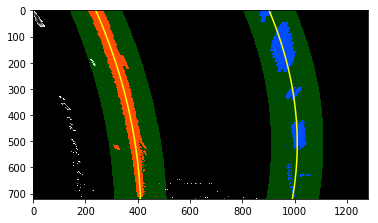

In [14]:
binary_warped_gray = warped_binary[:,:,2]
left_fit,right_fit = find_lanes(binary_warped_gray)

In [15]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image

def cal_radius_of_curvature(binary_img,left_fit,right_fit):

    # Measure radius of curvature at y-value closest to car
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx =right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    # Fit polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
  
    # Calculate radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius_of_curvature = (left_curverad+right_curverad)/2
    print(left_curverad, right_curverad)

    return radius_of_curvature

curvature = cal_radius_of_curvature(warped_binary,left_fit,right_fit)
print ("Radius of curvature is {}".format(curvature))


591.995340166 395.667606811
Radius of curvature is 493.8314734888317
